In [17]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from varclushi import VarClusHi
import statsmodels.api as sm

In [2]:
df = pd.read_csv("mmf_data2.csv", encoding='utf-8')

In [3]:
# Q2.3: Target Variable
target_cols = [f"t{month}" for month in range(1, 13)]
df["target"] = df[target_cols].sum(axis=1).apply(lambda x: 1 if x else 0)

In [4]:
# Q2.4: Population Exclusions
print(f"number of customers in the population before exclusions: {df.shape[0]}")
df = df.drop(df[df["WIDELYHD"] == "Y"].index).reset_index(drop=True)
df = df.drop(df[df["deceased"] > 0].index).reset_index(drop=True)
print(f"number of customers in the population after exclusions: {df.shape[0]}")

number of customers in the population before exclusions: 9028
number of customers in the population after exclusions: 9012


In [5]:
# Q2.5: Modeling Population
default_counts = df["target"].value_counts()
print("total population")
print("number of default customers: ", default_counts[1])
print("number of non-default customers: ", default_counts[0])
print("default rate: ", default_counts[1]/df.shape[0])

default_counts_by_timekey = df.groupby("TIME_KEY").target.agg(['sum', 'count'])
time_key_dict = {
    15076: "2014-01",
    15196: "2014-04",
    15316: "2014-07",
    15436: "2014-10"
}
for key in time_key_dict:
    print(f"\n{time_key_dict[key]}")
    print("number of default customers: ", default_counts_by_timekey.loc[key, "sum"])
    print("number of non-default customers: ", default_counts_by_timekey.loc[key, "count"] - default_counts_by_timekey.loc[key, "sum"])
    print("default rate: ", default_counts_by_timekey.loc[key, "sum"] / default_counts_by_timekey.loc[key, "count"])

total population
number of default customers:  900
number of non-default customers:  8112
default rate:  0.09986684420772303

2014-01
number of default customers:  219
number of non-default customers:  1967
default rate:  0.10018298261665141

2014-04
number of default customers:  236
number of non-default customers:  2004
default rate:  0.10535714285714286

2014-07
number of default customers:  206
number of non-default customers:  2039
default rate:  0.09175946547884187

2014-10
number of default customers:  239
number of non-default customers:  2102
default rate:  0.10209312259718069


In [6]:
# Q2.6: Explanatory Variables
debit_cols = ["debit_curr"] + [f"debit_prev{month}" for month in range(1, 13)]
credit_cols = ["credit_curr"] + [f"credit_prev{month}" for month in range(1, 13)]

def get_linear_trend(row, t=np.arange(0, -13, -1)):
    reg = LinearRegression().fit(t.reshape(-1, 1), row.to_numpy())
    return reg.coef_[0]

df["debit_max"] = df[debit_cols].max(axis=1)
df["debit_min"] = df[debit_cols].min(axis=1)
df["debit_avg"] = df[debit_cols].mean(axis=1)
df["debit_stdev"] = df[debit_cols].std(axis=1)
df["debit_trend"] = df[debit_cols].apply(lambda row: get_linear_trend(row), axis=1)
debit_new_cols = ["debit_max", "debit_min", "debit_avg", "debit_stdev", "debit_trend"]

df["credit_max"] = df[credit_cols].max(axis=1)
df["credit_min"] = df[credit_cols].min(axis=1)
df["credit_avg"] = df[credit_cols].mean(axis=1)
df["credit_stdev"] = df[credit_cols].std(axis=1)
df["credit_trend"] = df[credit_cols].apply(lambda row: get_linear_trend(row), axis=1)
credit_new_cols = ["credit_max", "credit_min", "credit_avg", "credit_stdev", "credit_trend"]

df["debit_credit_ratio"] = df["debit_avg"] / df["credit_avg"]
# monthly debit-to-credit ratio variables (variance too large)
# df["debit_credit_ratio_curr"] = df["debit_curr"] / df["credit_curr"]
# ratio_cols = ["debit_credit_ratio_avg", "debit_credit_ratio_curr"]
# for month in range(1, 13):
#     df[f"debit_credit_ratio{month}"] = df[f"debit_prev{month}"] / df[f"credit_prev{month}"]
#     ratio_cols.append(f"debit_credit_ratio{month}")

new_cols = debit_new_cols + credit_new_cols + ["debit_credit_ratio"]

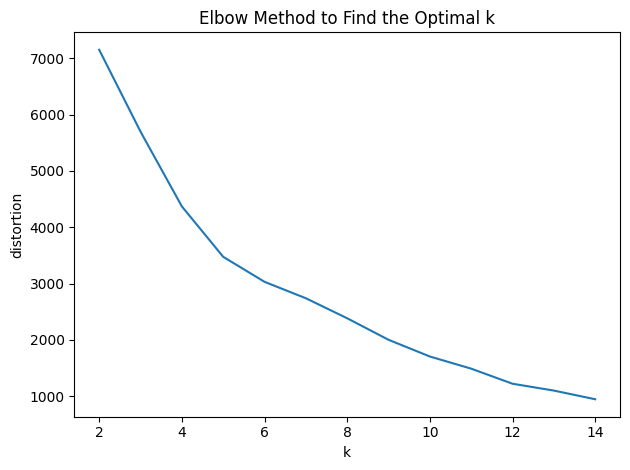

In [7]:
# Q2.7: Segmentation
cluster_cols = [
    'CUSTTYPE',
    'HIGHRISK',
    'STARTUP',
    'TERMCUST',
    'OLCUST',
    'VISACUST',
    'Out_of_Country',
    'SPP_Group_1',
    'SPP_Group_2',
    'DOCTOR_DENTIST_IND',
    'RESTAURANT_IND',
    'TRUCKING_IND',
    'RESTAURANT_OR_TRUCKING_IND',
    'SPP_LISTED_IND',
    'SPP_TARGETED_IND',
    'SPP_LISTED_OR_TARGETED_IND'
]

cluster_df = df.loc[:, cluster_cols]
for col in cluster_cols:
    # skip numeric variables
    if col == "CUSTTYPE":
        cluster_df["operating_account"] = cluster_df[col].map({"O": 1, "T": 0, "B": 1})
        cluster_df["term_account"] = cluster_df[col].map({"O": 0, "T": 1, "B": 1})
    else:
        cluster_df[col] = cluster_df[col].map({"Y": 1, "N": 0})

X_cluster = cluster_df.drop("CUSTTYPE", axis=1).to_numpy()
distortions = []
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=2000).fit(X_cluster)
    cluster_labels = kmeans.fit_predict(X_cluster)
    distortions.append(kmeans.inertia_)
    # silhouette_avg = silhouette_score(X_cluster, cluster_labels)
    # silhouette_scores.append(silhouette_avg)

fig, ax = plt.subplots()
ax.plot(np.arange(2, 15), distortions)
ax.set(xlabel="k", ylabel='distortion')
ax.set_title("Elbow Method to Find the Optimal k")
plt.tight_layout()
plt.show()

# we select k = 5 as the optimal number of cluster
clusterer = KMeans(n_clusters=5, random_state=2000).fit(X_cluster)
cluster_labels = clusterer.fit_predict(X_cluster)
df["cluster_num"] = cluster_labels

# fig, ax = plt.subplots()
# ax.plot(np.arange(2, 15), silhouette_scores)
# ax.set(xlabel="k", ylabel='silhouette score')
# ax.set_title("Silhouette Analysis to Find the Optimal k")
# plt.tight_layout()
# plt.show()

In [8]:
# Q3.2.1: Pre-Screening
processed_cols = [col[4:] for col in df.columns if col.startswith("GRP_")]
benchmark_cols = [col for col in df.columns if col.startswith("benchmark")]
population_exclusion_cols = ["WIDELYHD", "deceased"]
index_cols = ["tu_seq_id", "TIME_KEY"]
constant_cols = list(df.loc[:, df.nunique() == 1].columns)
# sparse_cols = list(df.loc[:, df.isna().sum() > 0.1*df.shape[0]].columns)
sparse_cols = list(df.loc[:, df.isna().sum() > 0].columns)

cols_to_ignore = sum(
    [
        processed_cols,
        target_cols, ["target"],
        benchmark_cols,
        new_cols,
        debit_cols,
        credit_cols,
        population_exclusion_cols,
        index_cols,
        constant_cols,
        sparse_cols
    ],
    []
)

prescreened_cols = [col for col in df.columns if not (col.startswith("GRP_") or col.startswith("WOE_") or col in cols_to_ignore)]

In [9]:
# Q3.2.2: Univariate Screening
def get_WOE_IV(df, col, preprocessed=False):
    df_groupby = df.groupby(col).target.agg(['sum', 'count'])
    df_groupby["f_B"] = df_groupby["sum"] / df.target.sum()  # distribution of default ("bad") customers
    df_groupby["f_G"] = (df_groupby["count"] - df_groupby["sum"]) / (df.shape[0] - df.target.sum())  # distribution of non-default ("good") customers
    if preprocessed:
        WOE_df = df[[col, "WOE_" + col.replace("GRP_", "")]].drop_duplicates()
        WOE_dict = dict(zip(WOE_df[col], WOE_df["WOE_" + col.replace("GRP_", "")]))
        df_groupby["WOE"] = df_groupby.index.to_series().map(WOE_dict)
    else:
        df_groupby["WOE"] = np.log(df_groupby["f_G"] / df_groupby["f_B"])
    df_groupby["IV"] = (df_groupby["f_G"] - df_groupby["f_B"]) * df_groupby["WOE"]
    return df_groupby


bins_dict = {
    "debit_max": np.linspace(25000, 50000, 11),
    "debit_min": [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 25000],
    "debit_avg": np.linspace(10000, 40000, 11),
    "debit_stdev": np.linspace(6000, 21000, 11),
    "debit_trend": [-4000, -2400, -1600, -800, 0, 800, 1600, 2400, 4000],
    "credit_max": [20000, 29000, 32000, 35000, 38000, 41000, 44000, 47000, 50000],
    "credit_min": [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000],
    "credit_avg": [10000, 16000, 19000, 22000, 25000, 28000, 31000, 34000, 37000, 40000],
    "credit_stdev": [6500, 9500, 11000, 12500, 14000, 15500, 17000, 18500, 21500],
    "credit_trend": [-4100, -2460, -1640, -820, 0, 820, 1640, 2460, 4100],
    "debit_credit_ratio": [0.3, 0.54, 0.78, 1.02, 1.26, 1.5, 1.74, 1.98, 2.7]
}

for col in new_cols:
    df[f"GRP_{col}"] = pd.cut(df[col], bins_dict[col], labels=np.arange(1, len(bins_dict[col])))
df["GRP_TBSAT01"] = pd.cut(df["TBSAT01"], [-8, -1, 0, 1, 2, 3, 4, 5, 7, 10, 30], labels=np.arange(1, 11))
df["WOE_TBSAT01"] = df["GRP_TBSAT01"].map(dict(zip(get_WOE_IV(df, "GRP_TBSAT01").index, get_WOE_IV(df, "GRP_TBSAT01").WOE)))
df["GRP_cust_max_dlq_3mos"] = pd.cut(df["cust_max_dlq_3mos"], [-1, 0, 1, 2, 6], labels=np.arange(1, 5))
df["WOE_cust_max_dlq_3mos"] = df["GRP_cust_max_dlq_3mos"].map(dict(zip(get_WOE_IV(df, "GRP_cust_max_dlq_3mos").index, get_WOE_IV(df, "GRP_cust_max_dlq_3mos").WOE)))

# encoding categorical variables
for col in prescreened_cols:
    # skip numeric variables
    if col in ['cust_max_dlq_3mos', 'agri_cust', 'TBSAT01']:
        continue
    elif col == "CUSTTYPE":
        df["operating_account"] = df[col].map({"O": 1, "T": 0, "B": 1})
        df["term_account"] = df[col].map({"O": 0, "T": 1, "B": 1})
    else:
        df[col] = df[col].map({"Y": 1, "N": 0})

# for col in new_cols:
#     df_groupby = get_WOE_IV(df, f"GRP_{col}")
#     print(col)
#     print(df_groupby)
#     print(df_groupby.IV.sum())

IV_dict = dict()
GRP_cols = [col for col in df.columns if col.startswith("GRP_")]  # this includes processed columns and new variables
cols_to_verify_with_IV = prescreened_cols + GRP_cols + ["operating_account", "term_account"]
for col in cols_to_verify_with_IV:
    # these variables have already been processed into different columns
    if col in ["CUSTTYPE", "TBSAT01", "cust_max_dlq_3mos"]:
        continue
    df_groupby = get_WOE_IV(df, col)
    # IV_dict[col] = df_groupby.IV.sum()
    IV_dict[col.replace("GRP_", "WOE_")] = df_groupby.IV.sum()
    # print(col, df_groupby.IV.sum())
    # print(df_groupby)

sorted_cols_by_IV = sorted(IV_dict.items(), key=lambda x: -x[1])
selected_cols = [x[0] for x in sorted_cols_by_IV if x[1] > 0.1]
selected_cols = [x for x in selected_cols if x not in ["Out_of_Country", "WOE_PD_Total_Scorecard_Points"]]

In [10]:
# Q3.2.3: Multivariate Screening
df_var_cluster = df.loc[:, selected_cols]
var_clusterer = VarClusHi(df_var_cluster, maxeigval2=2)
var_clusterer.varclus()
print(var_clusterer.info)
print(var_clusterer.rsquare)
df_rsquare_ratio = var_clusterer.rsquare
df_rsquare_ratio["IV"] = df_rsquare_ratio["Variable"].map(IV_dict)
cols_max_IV = df_rsquare_ratio[df_rsquare_ratio.groupby(['Cluster'])["IV"].transform(max) == df_rsquare_ratio["IV"]].Variable.to_numpy()
cols_min_ratio = df_rsquare_ratio[df_rsquare_ratio.groupby(['Cluster'])["RS_Ratio"].transform(min) == df_rsquare_ratio["RS_Ratio"]].Variable.to_numpy()
candidate_cols = list(cols_max_IV) + list(cols_min_ratio)
candidate_cols = sorted(list(set(candidate_cols)))

  Cluster N_Vars   Eigval1   Eigval2   VarProp
0       0     18  7.765835  1.829263  0.431435
1       1     12  7.593738  1.182550  0.632812
2       2      8  3.928507  1.516343  0.491063
3       3      8  4.200405  1.612878  0.525051
4       4      9  4.387612  1.523856  0.487512
5       5     12  6.544548  1.447001  0.545379
6       6     13  7.268132  1.592234  0.559087
7       7      4  2.768118  0.859483  0.692030
8       8      6  3.521030  0.857198  0.586838
9       9      9  5.336674  1.126232  0.592964
    Cluster        Variable    RS_Own     RS_NC  RS_Ratio
0         0     WOE_BCC5830  0.616866  0.310722  0.555848
1         0  WOE_CVPRAGG501  0.689049  0.272604  0.427486
2         0     WOE_BCA5030  0.660815  0.317916  0.497277
3         0  WOE_CVPRAGG907  0.654874  0.214634  0.439446
4         0     WOE_BCC3515  0.576050  0.258073  0.571417
..      ...             ...       ...       ...       ...
94        9    WOE_TBSAT33A  0.573834  0.322838  0.629341
95        9    WOE_

In [11]:
# Q2.8: Sampling Methodology (more convenient to split after processing)
df["cluster_num"] = cluster_labels
df_test = df[df["TIME_KEY"] == 15436].reset_index(drop=True)
df_train = df[df["TIME_KEY"] != 15436].reset_index(drop=True)
dfs_test = [df_test[df_test.cluster_num == i].reset_index(drop=True) for i in range(5)]
dfs = [df_train[df_train.cluster_num == i].reset_index(drop=True) for i in range(5)]
dfs_train, dfs_val = [None for _ in range(5)], [None for _ in range(5)]
for i in range(5):
    dfs_train[i], dfs_val[i], _, _ = train_test_split(dfs[i], dfs[i]["target"], stratify=dfs[i]["target"], test_size=0.3, random_state=2000)

In [37]:
# Q3.3
models = []
final_cols = []
for i in range(5):
    print(i)
    curr_cols = candidate_cols
    model = sm.Logit(dfs_train[i].target, dfs_train[i].loc[:, curr_cols]).fit(disp=False)
    min_bic = model.bic
    while True:
        best_model = None
        best_bic = np.inf
        best_col = None
        for subset in list(itertools.combinations(curr_cols, len(curr_cols)-1)):
            reg = sm.Logit(dfs_train[i].target, dfs_train[i].loc[:, subset]).fit(disp=False)
            if reg.bic < best_bic:
                best_bic = reg.bic
                best_model = reg
                best_col = subset
        if best_bic < min_bic:
            min_bic = best_bic
            model = reg
            curr_cols = best_col
        else:
            break
    models.append(model)
    final_cols.append(curr_cols)
    print(curr_cols)
    print(model.summary())

0
('WOE_ALL2327', 'WOE_CVSC100', 'WOE_TBSG001B', 'WOE_cust_max_dlq_3mos', 'WOE_dda_av_bal')
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  480
Model:                          Logit   Df Residuals:                      475
Method:                           MLE   Df Model:                            4
Date:                Sat, 10 Dec 2022   Pseudo R-squ.:                -0.03908
Time:                        14:16:45   Log-Likelihood:                -168.88
converged:                       True   LL-Null:                       -162.53
Covariance Type:            nonrobust   LLR p-value:                     1.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WOE_ALL6200               0.3346      0.292      1.147      0.251      -0.237       0.906
WOE_CV

In [13]:
# for col in new_cols:
#     fig, ax = plt.subplots()
#     ax.hist(df[col], bins=20)
#     ax.set(xlabel=col, ylabel='frequency')
#     plt.tight_layout()
#     plt.show()